In [36]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [37]:
gdf = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestID/metadata/PureForestID-patches.gpkg")
gdf = gdf[gdf.split.isin(["test","val"])]
gdf = gdf[["split", "patch_num", "bdforet_identifier","bdforet_cat_code", "bdforet_cat_name","inventory_species_label", ]]
print(gdf.columns)
gdf.head()

Index(['split', 'patch_num', 'bdforet_identifier', 'bdforet_cat_code',
       'bdforet_cat_name', 'inventory_species_label'],
      dtype='object')


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label
0,val,00035_00000,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
1,val,00035_00001,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
2,val,00035_00002,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
3,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
4,val,00035_00004,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14


In [39]:
PREDICTIONS_FOLDER_VAL = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-37-05")
PREDICTIONS_FOLDER_TEST = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-36-40")
df_val = pd.read_csv(PREDICTIONS_FOLDER_VAL / "predictions.csv")
df_test = pd.read_csv(PREDICTIONS_FOLDER_TEST / "predictions.csv")
df = pd.concat([df_val, df_test])
print(df.shape)

mapping = {0: "FF1-09-09_Hêtre",
  1: "FF1-10-10_Châtaignier",
  2: "FF1-14-14_Robinier",
  3: "FF1G01-01_Chêne_décidus",
  4: "FF1G06-06_Chêne_sempervirent",
  5: "FF2-51-51_Pin_maritime",
  6: "FF2-52-52_Pin_sylvestre",
  7: "FF2-57-57_Pin_alep",
  8: "FF2-63-63-Mélèze",
  9: "FF2-64-64_Douglas",
  10: "FF2G53-53_Pin_laricio_Pin_noir",
  11: "FF2G61-61_Sapin-Epicéa"}
df["targets"] = df["targets"].apply(lambda t: mapping[t])
df["preds"] = df["preds"].apply(lambda t: mapping[t])
df.head()

(41891, 3)


,patch_id,preds,targets
0,00328_02538,FF1-09-09_Hêtre,FF2-52-52_Pin_sylvestre
1,00123_01544,FF2G53-53_Pin_laricio_Pin_noir,FF2G53-53_Pin_laricio_Pin_noir
2,00451_00038,FF1-09-09_Hêtre,FF2-52-52_Pin_sylvestre
3,00328_02825,FF2-64-64_Douglas,FF2-52-52_Pin_sylvestre
4,00213_00121,FF1G06-06_Chêne_sempervirent,FF1G06-06_Chêne_sempervirent


In [40]:
merge = gdf.merge(df, left_on="patch_num", right_on="patch_id", how="inner")
# merge["OK"] = (merge["preds"] == merge["targets"]).astype(int)
# merge["NOK"] = (merge["preds"] != merge["targets"]).astype(int)
print(len(merge))
merge.head()

41891


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label,patch_id,preds,targets
0,val,00035_00000,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00000,FF1-14-14_Robinier,FF1-14-14_Robinier
1,val,00035_00001,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00001,FF1-14-14_Robinier,FF1-14-14_Robinier
2,val,00035_00002,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00002,FF1-14-14_Robinier,FF1-14-14_Robinier
3,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00003,FF1-14-14_Robinier,FF1-14-14_Robinier
4,val,00035_00004,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00004,FF1-14-14_Robinier,FF1-14-14_Robinier


In [41]:
groups = merge.groupby(["bdforet_identifier","bdforet_cat_code","targets","preds"]).size().reset_index()
pivot = groups.pivot(index=["bdforet_identifier","targets"],columns="preds",values=0).fillna(0).astype(int)
pivot["consensus"] = pivot.idxmax(axis=1)
pivot = pivot.reset_index()
pivot["accurate"] = pivot["consensus"] == pivot["targets"]
pivot.to_csv(PREDICTIONS_FOLDER_VAL/"predictions-pivot-by-polygon.csv")
pivot

preds,bdforet_identifier,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
0,FORESTIE0000000000100093,FF1-14-14_Robinier,0,0,12,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
1,FORESTIE0000000000100104,FF1-14-14_Robinier,0,0,36,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
2,FORESTIE0000000000100240,FF1-14-14_Robinier,0,0,9,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
3,FORESTIE0000000000401455,FF1G01-01_Chêne_décidus,0,0,83,46,33,3,0,0,0,0,0,FF1-14-14_Robinier,False
4,FORESTIE0000000000402323,FF1G01-01_Chêne_décidus,130,31,0,651,1,2,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,FORESTIE0000000008208414,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
89,FORESTIE0000000008208450,FF1-14-14_Robinier,0,0,4,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
90,FORESTIE0000000008208460,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
91,FORESTIE0000000008210212,FF1G01-01_Chêne_décidus,1,0,3877,1044,0,1,0,1,0,1,0,FF1-14-14_Robinier,False


In [42]:
synthesis = pivot.groupby("targets").agg({"accurate":"mean","bdforet_identifier":"size"}).round(2)
synthesis = synthesis.rename(columns={"accurate":"accuracy","bdforet_identifier":"num_bdforet_polygons"})
synthesis.to_csv(PREDICTIONS_FOLDER_VAL/"predictions-accuracy-by-class.csv")
synthesis


preds,accuracy,num_bdforet_polygons
targets,,
FF1-09-09_Hêtre,0.67,6
FF1-10-10_Châtaignier,0.40,5
FF1-14-14_Robinier,0.92,24
FF1G01-01_Chêne_décidus,0.50,14
FF1G06-06_Chêne_sempervirent,0.83,6
FF2-52-52_Pin_sylvestre,0.75,8
FF2-57-57_Pin_alep,0.75,4
FF2-63-63-Mélèze,1.00,2
FF2-64-64_Douglas,0.70,10


In [43]:
synthesis.sort_values("accuracy",ascending=False)

preds,accuracy,num_bdforet_polygons
targets,,
FF2-63-63-Mélèze,1.00,2
FF2G61-61_Sapin-Epicéa,1.00,8
FF1-14-14_Robinier,0.92,24
FF1G06-06_Chêne_sempervirent,0.83,6
FF2G53-53_Pin_laricio_Pin_noir,0.83,6
FF2-52-52_Pin_sylvestre,0.75,8
FF2-57-57_Pin_alep,0.75,4
FF2-64-64_Douglas,0.70,10
FF1-09-09_Hêtre,0.67,6


In [44]:
# accuracy at the polygon level
OK = len(pivot[pivot.accurate])
NOK = len(pivot[~pivot.accurate])
OK/(OK+NOK)

0.7634408602150538

In [45]:
# erreurs
non_accurates = pivot[~pivot.accurate].sort_values("targets")
non_accurates

preds,bdforet_identifier,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
6,FORESTIE0000000000403437,FF1-09-09_Hêtre,1,0,14,68,0,4,0,15,0,1,0,FF1G01-01_Chêne_décidus,False
57,FORESTIE0000000004302294,FF1-09-09_Hêtre,34,0,12,53,0,1,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
62,FORESTIE0000000004609242,FF1-10-10_Châtaignier,0,0,1,37,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
47,FORESTIE0000000003807482,FF1-10-10_Châtaignier,0,0,8,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
83,FORESTIE0000000008109742,FF1-10-10_Châtaignier,0,0,68,3,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
64,FORESTIE0000000004710749,FF1-14-14_Robinier,0,0,0,1,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
33,FORESTIE0000000002436292,FF1-14-14_Robinier,0,25,2,0,0,0,0,0,3,0,24,FF1-10-10_Châtaignier,False
3,FORESTIE0000000000401455,FF1G01-01_Chêne_décidus,0,0,83,46,33,3,0,0,0,0,0,FF1-14-14_Robinier,False
82,FORESTIE0000000007119243,FF1G01-01_Chêne_décidus,1,0,284,0,0,0,0,0,16,0,0,FF1-14-14_Robinier,False
56,FORESTIE0000000003809798,FF1G01-01_Chêne_décidus,0,0,1,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False


In [46]:
# Lien entre erreur et taille de polygone -> pas vraiment.
non_accurates["num_patches_in_polygon"] = non_accurates[non_accurates.columns[2:13]].sum(axis=1)
non_accurates[["targets","consensus","num_patches_in_polygon"]]

preds,targets,consensus,num_patches_in_polygon
6,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,103
57,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,100
62,FF1-10-10_Châtaignier,FF1G01-01_Chêne_décidus,38
47,FF1-10-10_Châtaignier,FF1-14-14_Robinier,8
83,FF1-10-10_Châtaignier,FF1-14-14_Robinier,71
64,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,1
33,FF1-14-14_Robinier,FF1-10-10_Châtaignier,54
3,FF1G01-01_Chêne_décidus,FF1-14-14_Robinier,165
82,FF1G01-01_Chêne_décidus,FF1-14-14_Robinier,301
56,FF1G01-01_Chêne_décidus,FF1-14-14_Robinier,1


In [47]:
# Confusion matrix at polygon level
counts = pivot.groupby(["targets","consensus"]).size().reset_index().rename(columns={0:"count"})
cm = counts.pivot(index="targets",columns="consensus",values="count").fillna(0).astype(int)
cm

consensus,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa
targets,,,,,,,,,,,
FF1-09-09_Hêtre,4,0,0,2,0,0,0,0,0,0,0
FF1-10-10_Châtaignier,0,2,2,1,0,0,0,0,0,0,0
FF1-14-14_Robinier,0,1,22,1,0,0,0,0,0,0,0
FF1G01-01_Chêne_décidus,1,1,5,7,0,0,0,0,0,0,0
FF1G06-06_Chêne_sempervirent,0,0,0,0,5,0,0,0,1,0,0
FF2-52-52_Pin_sylvestre,0,0,0,1,1,6,0,0,0,0,0
FF2-57-57_Pin_alep,0,0,0,0,0,0,3,0,1,0,0
FF2-63-63-Mélèze,0,0,0,0,0,0,0,2,0,0,0
FF2-64-64_Douglas,0,0,1,0,0,0,0,0,7,2,0


In [48]:
cm.index

Index(['FF1-09-09_Hêtre', 'FF1-10-10_Châtaignier', 'FF1-14-14_Robinier',
       'FF1G01-01_Chêne_décidus', 'FF1G06-06_Chêne_sempervirent',
       'FF2-52-52_Pin_sylvestre', 'FF2-57-57_Pin_alep', 'FF2-63-63-Mélèze',
       'FF2-64-64_Douglas', 'FF2G53-53_Pin_laricio_Pin_noir',
       'FF2G61-61_Sapin-Epicéa'],
      dtype='object', name='targets')

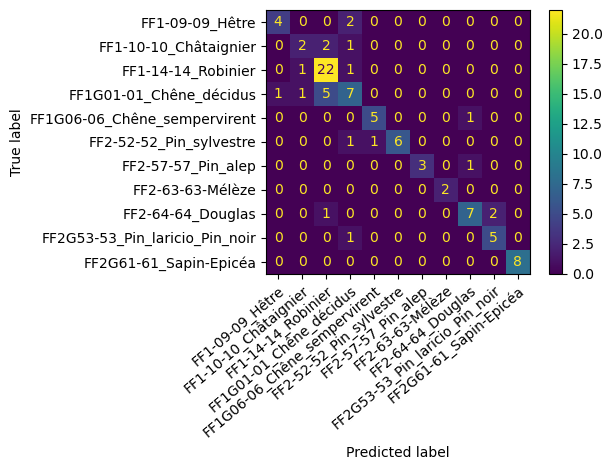

In [73]:
ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
import matplotlib.pyplot as plt
plt.xticks(rotation = 40,  rotation_mode="anchor",ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.tight_layout()
plt.savefig(PREDICTIONS_FOLDER_TEST / "CM-by-polygon-val-and-test.png")

In [85]:
pivot["second_consensus"] = pivot[[c for c in pivot.columns if c.startswith("FF")]].apply(lambda row: row.nlargest(2).index[-1], axis=1)
pivot["accurate_top2"] =  (pivot["second_consensus"] == pivot["targets"]) | pivot["accurate"]

synthesis = pivot.groupby("targets").agg({"accurate_top2":"mean","bdforet_identifier":"size"}).round(2)
synthesis = synthesis.rename(columns={"accurate_top2":"accuracy_top2","bdforet_identifier":"num_bdforet_polygons"})
synthesis.to_csv(PREDICTIONS_FOLDER_VAL/"predictions-top2-accuracy-by-class.csv")
synthesis.sort_values("accuracy_top2",ascending=False)

preds,accuracy_top2,num_bdforet_polygons
targets,,
FF1G06-06_Chêne_sempervirent,1.00,6
FF2-57-57_Pin_alep,1.00,4
FF2-63-63-Mélèze,1.00,2
FF2G61-61_Sapin-Epicéa,1.00,8
FF1-14-14_Robinier,0.92,24
FF2-52-52_Pin_sylvestre,0.88,8
FF1-09-09_Hêtre,0.83,6
FF2G53-53_Pin_laricio_Pin_noir,0.83,6
FF1G01-01_Chêne_décidus,0.79,14


In [86]:
# accuracy at the polygon level
OK = len(pivot[pivot.accurate_top2])
NOK = len(pivot[~pivot.accurate_top2])
OK/(OK+NOK)

0.8494623655913979

In [52]:
# Aggrégation aux polygones initiaux
annotations = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestID/metadata/PureForestID-annotations.gpkg")
# gdf = gdf[gdf.split.isin(["test","val"])]
# gdf = gdf[["bdforet_identifier", "patch_num", "bdforet_identifier","bdforet_cat_code", "bdforet_cat_name","inventory_species_label", ]]
print(annotations.columns)
print(len(annotations))
annotations.head()

Index(['inventory_species_label', 'french_department_id',
       'rgbnir_imagery_year', 'bdforet_identifier', 'if_idp', 'index',
       'geometry'],
      dtype='object')
606


,inventory_species_label,french_department_id,rgbnir_imagery_year,bdforet_identifier,if_idp,index,geometry
0,14,38,2021,FORESTIE0000000003807719,None,polygon_id_0000,"POLYGON ((847835.000 6496796.300, 847836.800 6..."
1,10,46,2019,FORESTIE0000000004607749,1604803,polygon_id_0001,"POLYGON ((575671.409 6405360.047, 575662.320 6..."
2,09,15,2020,FORESTIE0000000001505240,1114880,polygon_id_0002,"POLYGON ((657240.199 6438851.684, 657260.651 6..."
3,51,40,2021,FORESTIE0000000004030982,1103823,polygon_id_0003,"POLYGON ((458895.878 6336277.228, 458905.620 6..."
4,57A,24,2021,None,None,polygon_id_0004,"MULTIPOLYGON (((917888.499 6245709.976, 917892..."


In [64]:
# We merge when a bd foret polygon was splitted into n polygons of the same species
annotations = annotations.dissolve(by=["inventory_species_label","bdforet_identifier"], as_index=False)
annotations

,inventory_species_label,bdforet_identifier,geometry,french_department_id,rgbnir_imagery_year,if_idp,index
0,02,FORESTIE0000000001504492,"POLYGON ((650589.255 6474224.790, 650586.015 6...",15,2020,1118642,polygon_id_0413
1,02,FORESTIE0000000002446444,"POLYGON ((539813.712 6497050.060, 539831.336 6...",24,2021,1629768,polygon_id_0430
2,02,FORESTIE0000000003215110,"POLYGON ((523300.500 6329284.500, 523307.820 6...",32,2019,1118152,polygon_id_0389
3,02,FORESTIE0000000004018714,"POLYGON ((464953.738 6325849.944, 464965.732 6...",40,2021,1126100,polygon_id_0503
4,02,FORESTIE0000000008209845,"POLYGON ((556092.800 6331011.000, 556093.300 6...",82,2019,1628880,polygon_id_0151
...,...,...,...,...,...,...,...
420,64,FORESTIE0000000006907469,"MULTIPOLYGON (((819176.940 6571345.188, 819186...",69,2020,1111088,polygon_id_0156
421,64,FORESTIE0000000008721626,"POLYGON ((584949.773 6516474.790, 584965.444 6...",87,2020,1123804,polygon_id_0262
422,65,FORESTIE0000000001621704,"POLYGON ((473706.511 6469995.554, 473752.003 6...",16,2020,1608496,polygon_id_0108
423,71,FORESTIE0000000003417825,"POLYGON ((747887.480 6304378.939, 747974.674 6...",34,2021,1120364,polygon_id_0552


In [70]:
annotations_cm = annotations.merge(pivot, on="bdforet_identifier")
annotations_cm.to_file(PREDICTIONS_FOLDER_TEST / "bdforet_annotations_and_their_confusion.geojson")
print(PREDICTIONS_FOLDER_TEST)
annotations_cm

/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-36-40


,inventory_species_label,bdforet_identifier,geometry,french_department_id,rgbnir_imagery_year,if_idp,index,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,...,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
0,02,FORESTIE0000000002446444,"POLYGON ((539813.712 6497050.060, 539831.336 6...",24,2021,1629768,polygon_id_0430,FF1G01-01_Chêne_décidus,1,1,...,0,0,0,0,0,1,0,0,FF1-09-09_Hêtre,False
1,02,FORESTIE0000000003215110,"POLYGON ((523300.500 6329284.500, 523307.820 6...",32,2019,1118152,polygon_id_0389,FF1G01-01_Chêne_décidus,0,0,...,288,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
2,03,FORESTIE0000000001504926,"POLYGON ((665899.589 6413824.735, 665884.909 6...",15,2020,1103343,polygon_id_0305,FF1G01-01_Chêne_décidus,0,0,...,36,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
3,03,FORESTIE0000000007119243,"POLYGON ((786277.233 6573804.909, 786290.995 6...",71,2020,1625081,polygon_id_0444,FF1G01-01_Chêne_décidus,1,0,...,0,0,0,0,0,16,0,0,FF1-14-14_Robinier,False
4,04,FORESTIE0000000003809798,"POLYGON ((867330.300 6478063.000, 867299.475 6...",38,2021,1618186,polygon_id_0177,FF1G01-01_Chêne_décidus,0,0,...,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,63,FORESTIE0000000000526662,"POLYGON ((977893.800 6415839.000, 977894.000 6...",05,2018,1638178,polygon_id_0204,FF2-63-63-Mélèze,3,0,...,3,0,4,0,534,0,0,0,FF2-63-63-Mélèze,True
89,64,FORESTIE0000000002323832,"MULTIPOLYGON (((648845.985 6520000.000, 648848...",23,2020,1103890,polygon_id_0114,FF2-64-64_Douglas,0,2,...,1,0,0,0,0,38,0,0,FF2-64-64_Douglas,True
90,64,FORESTIE0000000006905997,"MULTIPOLYGON (((814000.300 6534698.500, 814000...",69,2020,1110357,polygon_id_0272,FF2-64-64_Douglas,8,0,...,0,0,0,0,0,18,9,10,FF2-64-64_Douglas,True
91,64,FORESTIE0000000006906715,"MULTIPOLYGON (((813767.629 6566231.258, 813746...",69,2020,1654380,polygon_id_0159,FF2-64-64_Douglas,1,0,...,0,0,0,0,0,40,0,35,FF2-64-64_Douglas,True
